# __ПРОЕКТ: Разработка ML-модели предсказания судьбы стартапов__

## Задача проекта

На основе данных о стартапах, функционировавших в период с 1970 по 2018 годы, разработать ML-модель и предсказать, какие из них закроются.

## Краткий план работы

| **№ п/п** | **Задача** | **Срок выполнения** |
| :---: | :--- | :---: |
|1.|Импортировать необходимые библиотеки. Загрузить данные. Провести их осмотр. Сделать выводы.|28.08.2024|
|2.|Провести предобработку данных. Принять решение по обработке пропусков.|30.08.2024|
|3.|Провести исследовательский анализ данных.|01.09.2024|
|4.|Провести подготовку данных. Отобрать и сконструировать признаки. Оценить корелляцию признаков.|03.09.2024|
|5.|Выбрать и обучить модель. Провести оценку качества ML-модели по метрике F1 на валидационгой выборке.|05.09.2024|
|6.|С использованием обученной ML-модели получить прогнозы на тестовой выборке.|05.09.2024|
|7.|Оценить важность признаков.|06.09.2024|
|8.|Сформулировать выводы.|07.09.2024|
|9.|Подготовить отчет о проделаной работе.|07.09.2024|

## Исходные данные

Наборы данных:
- __kaggle_startups_train_01.csv__ - информация о 53 000 стартапах, которые будут использоваться в качестве обучающих данных.
- __kaggle_startups_test_01.csv__ - информация о 13 000 стартапах, которые будут использоваться в качестве тестовых данных.
- __kaggle_startups_sample_submit_01.csv__ - файл с примером предсказаний в правильном формате.


| **№ п/п** | **Наименование признака** | **Описание** |
| :---: | :--- | :--- |
|1.|__name__|Название стартапа|
|2.|__category_list__|Список категорий, к которым относится стартап|
|3.|__funding_total_usd__|Общая сумма финансирования в USD|
|4.|__status__|__Целевая переменная__. Статус стартапа (закрыт или действующий)|
|5.|__country_code__|Код страны|
|6.|__state_code__|Код штата|
|7.|__region__|Регион|
|8.|__city__|Город|
|9.|__funding_rounds__|Количество раундов финансирования|
|10.|__founded_at__|Дата основания|
|11.|__first_funding_at__|Дата первого раунда финансирования|
|12.|__last_funding_at__|Дата последнего раунда финансирования|
|13.|__closed_at__|Дата закрытия стартапа (если применимо)|
|14.|__lifetime__|Время существования стартапа в днях|

## Импорт библиотек, определение констант и некоторых переиспользуемых функций

### Импорт библиотек и определение констант

In [1]:
# загружаем основные библиотеки
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import warnings
import logging

warnings.filterwarnings('ignore')
logging.getLogger("optuna").setLevel(logging.CRITICAL)

# модуль для форматирования подписей к осям графиков
from matplotlib import ticker

# библиотеку для работы с корреляцией
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем классы для автоматизации, подбора гиперпараметров и разделения выборки
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from optuna.integration import OptunaSearchCV

# загружаем классы для подготовки данных
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

# загружаем функции для работы с метриками
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import accuracy_score, f1_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

# загружаем классы для создания кастомных трасформеров
from sklearn.base import BaseEstimator, TransformerMixin

# загружаем нужные модели
from catboost import CatBoostClassifier
import lightgbm as lgb

# загружаем класс для преобразования текста в векторное представление
from gensim.models import Word2Vec

# загружаем модуль для работы с датой
from datetime import datetime

# инициализация констант
RANDOM_STATE = 37
TEST_SIZE = 0.2

# инициализируем дату выгрузки данных в строковом формате
UPLOADING_DATE_STR = '2018-01-01'

# установка опции для отображения всех столбцов и чисел
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option("display.max.columns", None)
pd.set_option('display.max_colwidth', None)

# устанавливаем тему для графиков seaborn
sns.set_theme(style="whitegrid")

# инициализация значения цветов для графиков
palette = ['palegreen', 'lightcoral']

### Определение переиспользуемых функций

Напишем класс для подавления логгирования при обучениии моделей для использования совместно с конструкцией `with`

In [2]:
class SuppressOutput:
    def __enter__(self):
        self._stdout = sys.stdout
        self._stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self._stdout
        sys.stderr = self._stderr

Определим функцию для отображения количества и долей пропусков в признаках

In [3]:
# функция принимает на вход датасет pandas
def display_na_rates(df):
    # соединяем 2 Series: в первом количество пропусков по столбцам,
    # во втором из доля по отношению к общему количеству строк. Для этого используем метод pd.concat()
    missing_values = pd.concat(
        [df.isna().sum(), df.isna().sum() / len(df)], axis=1
    )
    # называем столбцы понятными именами
    missing_values.columns = ['Missing values', 'Missing rate']
    # сортируем missing_values убыванию
    missing_values = missing_values.sort_values(by='Missing values', ascending=False)
    # форматируем стиль для вывода "красивых" процентов
    missing_values['Missing rate'] = missing_values['Missing rate'].apply(lambda rate : f'{rate:.1%}')
    # отображаем таблицу с информацией о пропусках
    display(missing_values)
    pass

Определим функцию для отображения общей информации о датасете

In [4]:
# функция принимает на вход датасет pandas и имя для отображения
def show_data_info(df, name=None):
    print('Датасет', name)
    # выводим пример из семи случайно выбранных наблюдений
    display(df.sample(7))
    # выводим общую информацию
    display(df.info())
    # выводим информацию о количестве уникальных значений признаков
    display(
        pd.DataFrame(
            data = df.nunique(), columns = ['Уникальных значений']
        )
    )
    print('Описательные статистики')
    # отображаем основные описательные статистики
    display(df.describe().T)
    print('Пропуски')
    # отображаем таблицу с информацией о пропусках
    display_na_rates(df)
    print(f'Количество явных полных дубликатов в наборе {name}: {df.duplicated().sum()}')
    print()
    pass

## Загрузка данных и ознакомление с ними

In [5]:
# объявление локальных путей к датасетам
kaggle_startups_train_local_path = '/Users/sergey/Documents/Practicum/DS/3 module/Мастерская/kaggle_startups_train_28062024.csv'
kaggle_startups_test_local_path = '/Users/sergey/Documents/Practicum/DS/3 module/Мастерская/kaggle_startups_test_28062024.csv'
kaggle_startups_sample_submit_local_path = '/Users/sergey/Documents/Practicum/DS/3 module/Мастерская/kaggle_startups_sample_submit_28062024.csv'

In [6]:
# инициализация тренировочного датасета
train = pd.read_csv(kaggle_startups_train_local_path)

In [7]:
# инициализация тестового датасета
test = pd.read_csv(kaggle_startups_test_local_path)

Выводим информацию о тренировочных данных вызовом ранее определенной функции `show_data_info()`.

In [8]:
show_data_info(train, 'train')

Датасет train


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
47291,Paloma Mobile,Mobile,"1,500,000.00",operating,AUS,2,Sydney,Sydney,1,2010-11-06,2012-06-15,2012-06-15,NaN
14470,ONE RECOVERY,NaN,"6,983,583.00",operating,USA,CA,San Diego,Del Mar,1,2009-04-16,2010-07-21,2010-07-21,NaN
3608,Create! Art Collective,Art|Artists Globally|Design|Performing Arts,827.00,operating,USA,CA,SF Bay Area,Daly City,1,2013-09-01,2013-10-01,2013-10-01,NaN
50828,KLab,Games,"9,300,000.00",operating,SGP,NaN,Singapore,Singapore,1,2012-01-01,2013-07-19,2013-07-19,NaN
25146,SkyWire,App Marketing|Enterprises|Enterprise Software|Mobile|Point of Sale|Property Management|SMS,"1,673,537.00",operating,USA,NV,Las Vegas,Las Vegas,1,2005-11-11,2014-03-12,2014-03-12,NaN
40870,FleAffair.com,Art|Fashion|Handmade|Home & Garden|Internet|Jewelry|Local Businesses|Marketplaces|Online Shopping,"10,000.00",operating,IND,7,New Delhi,New Delhi,1,2013-08-11,2013-11-21,2013-11-21,NaN
30538,tenXer,Gamification|Software,"4,700,000.00",operating,USA,CA,SF Bay Area,San Francisco,2,2011-09-01,2011-09-01,2012-08-28,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

,Уникальных значений
name,52515
category_list,22105
funding_total_usd,15551
status,2
country_code,134
state_code,300
region,1036
city,4477
funding_rounds,19
founded_at,5402


Описательные статистики


,count,mean,std,min,25%,50%,75%,max
funding_total_usd,"42,447.00","18,247,480.66","187,117,301.32",1.00,"336,027.50","2,000,000.00","10,000,000.00","30,079,503,000.00"
funding_rounds,"52,516.00",1.74,1.37,1.00,1.00,1.00,2.00,19.00


Пропуски


,Missing values,Missing rate
closed_at,47599,90.6%
funding_total_usd,10069,19.2%
state_code,6763,12.9%
region,6359,12.1%
city,6359,12.1%
country_code,5502,10.5%
category_list,2465,4.7%
name,1,0.0%
status,0,0.0%
funding_rounds,0,0.0%


Количество явных полных дубликатов в наборе train: 0



Выводим информацию о тестовых данных вызовом ранее определенной функции `show_data_info()`.

In [9]:
show_data_info(test, 'test')

Датасет test


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
9716,4Soils,Apps|Education|Kids|Religion,"50,000.00",USA,CA,SF Bay Area,Stanford,1,2013-08-26,2013-08-26,2192
7005,enModus,Hardware + Software|Home Automation,"4,109,209.00",GBR,Y4,GBR - Other,Chepstow,3,2010-07-01,2014-02-17,2891
709,Factual,Databases,"27,000,000.00",USA,CA,Los Angeles,Los Angeles,3,2010-02-03,2010-12-09,4018
5676,Assignment Editor,News,"1,000,000.00",USA,IL,Chicago,Chicago,2,2001-03-31,2002-11-30,6759
3409,Mobile Content Networks,Mobile,"16,000,000.00",USA,CA,SF Bay Area,San Mateo,2,2006-10-24,2007-01-23,4462
11866,SkyBulls,Social Games|Stock Exchanges|University Students,"40,000.00",USA,CA,SF Bay Area,San Francisco,1,2013-03-14,2013-03-14,2192
5813,OBMedical,Health Care,"2,300,000.00",USA,FL,Gainesville,Newberry,1,2014-07-29,2014-07-29,2192


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

,Уникальных значений
name,13125
category_list,6206
funding_total_usd,4549
country_code,96
state_code,235
region,688
city,2117
funding_rounds,15
first_funding_at,3299
last_funding_at,3021


Описательные статистики


,count,mean,std,min,25%,50%,75%,max
funding_total_usd,"10,547.00","16,549,102.70","92,172,825.63",1.00,"320,000.00","2,000,000.00","10,000,000.00","4,715,000,000.00"
funding_rounds,"13,125.00",1.71,1.32,1.00,1.00,1.00,2.00,15.00
lifetime,"13,125.00","3,097.61","2,128.36",52.00,"1,726.00","2,526.00","3,866.00","17,167.00"


Пропуски


,Missing values,Missing rate
funding_total_usd,2578,19.6%
state_code,1695,12.9%
region,1589,12.1%
city,1587,12.1%
country_code,1382,10.5%
category_list,591,4.5%
name,0,0.0%
funding_rounds,0,0.0%
first_funding_at,0,0.0%
last_funding_at,0,0.0%


Количество явных полных дубликатов в наборе test: 0



### Промежуточные выводы по ознакомлению с данными

- Данные соответствуют описанию.
- Нейминг столбцов соостветствует принятым соглашениям.
- Данные не содержат явных дубликатов.
- В наборах данных есть пропуски. Для определения стратегии работы с пропусками необходимо провести дополнительный анализ.
- Данные в количественных признаках имеют большой разброс в масштабах. На этапе подготовки данных необходимо использовать скелеры для масштабирования.
- Признаки, содержащие дату, имеют строковый формат и требуют приведения к соответствующему типу данных (`datetime`).
- Данные в столбце `category_list` имеют слишком много уникальных значений. Если оставить их как есть, это приведет к переобучению модели и, как следствие, - к снижению метрики на тесте. Возможный подход - использование векторизации языковой моделью, например `Word2Vec`.
- Набор данных __kaggle_startups_train_01.csv__ не содержит признака `lifetime` (время существования стартапа в днях), но содержит дату основания стартапа (`founded_at`). Признак `lifetime` для тренировочного датасета можно восстановить как разницу между датой закрытия (датой выгрузки для работающих стартапов) и датой основания стартапа.

## Предобработка данных

### Приведение типов данных

Выполним приведение типа данных для признаков с датой (`str` to `datetime`). Используем функцию `to_datetime()` из библиотеки `pandas`.

In [10]:
train['founded_at'] = pd.to_datetime(train['founded_at'], format='%Y-%m-%d')

In [11]:
train['first_funding_at'] = pd.to_datetime(train['first_funding_at'], format='%Y-%m-%d')

In [12]:
train['closed_at'] = pd.to_datetime(train['closed_at'], format='%Y-%m-%d', errors='ignore')

In [13]:
train['last_funding_at'] = pd.to_datetime(train['last_funding_at'], format='%Y-%m-%d')

In [14]:
test['first_funding_at'] = pd.to_datetime(test['first_funding_at'], format='%Y-%m-%d')

In [15]:
test['last_funding_at'] = pd.to_datetime(test['last_funding_at'], format='%Y-%m-%d')

Проверим результат.

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


### Заполнение пропусков

#### Признак `funding_total_usd`

Для определения стратегии заполнения пропусков в колонке `funding_total_usd` изучим ее подробнее. Значения данного признака могут соотноситься с количеством раундов финансирования (`funding_rounds`). Посмотрим на описательные статистики `funding_rounds`.

In [18]:
train[train['funding_total_usd'].isna()]['funding_rounds'].describe()

count   10,069.00
mean         1.11
std          0.44
min          1.00
25%          1.00
50%          1.00
75%          1.00
max         10.00
Name: funding_rounds, dtype: float64

Диапазон значений `funding_rounds` для наблюдений с пропусками в `funding_total_usd` лежит в пределах от 1 до 10. Выведем график зависимости медианных значений `funding_total_usd`, агрегированных по `funding_rounds`. Определим функции для визуализации.

In [19]:
# функции для форматирования строк для подписей значений на осях графиков
def fmt_millions(x, pos):
    return f'{x / 1000000:.0f} млн.'

def int_fmt(x, pos):
    return f'{x:.0f}'

In [20]:
# создаем объект для форматирования сумм
millions_formatter = ticker.FuncFormatter(func=fmt_millions)

In [21]:
# создаем объект для форматирования сумм
int_formatter = ticker.FuncFormatter(func=int_fmt)

In [22]:
# функция агрегации медианного значения по количеству раундов
# возвращает сводную таблицу
def get_pivot_table(df):
    return df.pivot_table(
        index='funding_rounds',
        values='funding_total_usd',
        aggfunc='median'
    )

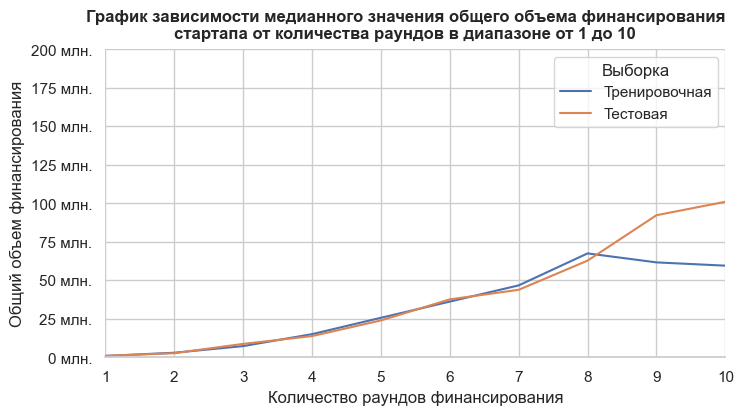

In [23]:
# задаем область рисования
fig, ax = plt.subplots(figsize=(8, 4))

# выводим график для тренировочного датасета
sns.lineplot(
    data=get_pivot_table(train),
    x='funding_rounds',
    y='funding_total_usd',
    label='Тренировочная',
    ax=ax
)

# выводим график для тестового датасета
sns.lineplot(
    data=get_pivot_table(test),
    x='funding_rounds',
    y='funding_total_usd',
    label='Тестовая',
    ax=ax
)

# подписываем легенду
ax.get_legend().set_title('Выборка')

# задаем название для графика
fig.suptitle(
    'График зависимости медианного значения общего объема финансирования\n\
стартапа от количества раундов в диапазоне от 1 до 10',
    fontsize=12,
    fontweight='bold'
)

# устанавливаем форматирования для значений осей
ax.yaxis.set_major_formatter(millions_formatter)
ax.xaxis.set_major_locator(ticker.FixedLocator(get_pivot_table(train).index))

# подписываем оси
ax.set_xlabel('Количество раундов финансирования')
ax.set_ylabel('Общий объем финансирования')

# устанавливаем пределы для отображения
plt.xlim(1, 10)
plt.ylim(0, 200000000)

# убираем лишнее
sns.despine(left=True)
plt.show()

Как видно по графику, медианное значения общего объема финансирования стартапа в зависит от количества раундов финансирования. Следовательно, пропуски в колонке `funding_total_usd` можно заполнить медианой с учетом количества раундов финансирования. Для этого используем функцию `transform()` из библиотеки `pandas`.

In [24]:
# заполняем пропуски на трейне
train['funding_total_usd'] = train['funding_total_usd'].fillna(
    train.groupby('funding_rounds')['funding_total_usd'].transform('median')
)

In [25]:
# заполняем пропуски на тесте
test['funding_total_usd'] = test['funding_total_usd'].fillna(
    train.groupby('funding_rounds')['funding_total_usd'].transform('median')
)

#### Другие признаки

Остальные пропуски заполним значением `Unknown`.

In [26]:
train['category_list'] = train['category_list'].fillna('Unknown')

In [27]:
test['category_list'] = test['category_list'].fillna('Unknown')

In [28]:
train['country_code'] = train['country_code'].fillna('Unknown')

In [29]:
test['country_code'] = test['country_code'].fillna('Unknown')

In [30]:
train['state_code'] = train['state_code'].fillna('Unknown')

In [31]:
test['state_code'] = test['state_code'].fillna('Unknown')

In [32]:
train['region'] = train['region'].fillna('Unknown')

In [33]:
test['region'] = test['region'].fillna('Unknown')

In [34]:
train['city'] = train['city'].fillna('Unknown')

In [35]:
test['city'] = test['city'].fillna('Unknown')

Проверим результат на тренировочной и тестовой выборках.

In [36]:
display_na_rates(train)

,Missing values,Missing rate
closed_at,47599,90.6%
name,1,0.0%
category_list,0,0.0%
funding_total_usd,0,0.0%
status,0,0.0%
country_code,0,0.0%
state_code,0,0.0%
region,0,0.0%
city,0,0.0%
funding_rounds,0,0.0%


In [37]:
display_na_rates(test)

,Missing values,Missing rate
name,0,0.0%
category_list,0,0.0%
funding_total_usd,0,0.0%
country_code,0,0.0%
state_code,0,0.0%
region,0,0.0%
city,0,0.0%
funding_rounds,0,0.0%
first_funding_at,0,0.0%
last_funding_at,0,0.0%


### Добавление признаков

#### Признак `lifetime`

В тестовой выборке имеется признак `lifetime` - время жизни стартапа в днях. Восстановим этот признак для тренировочной выборки. Для этого выполним следующие шаги:

1. Для работающих (на момент выгрузки) стартапов `lifetime` вычислим как разность между датой выгрузки и датой основания.
2. Для закрытых стартапов определим `lifetime` как разность между датой открытия и датой закрытия.

Определим функцию с реализацией данной логики.

In [38]:
# функция принимает на вход строку датасета
def get_lifetime(row):
    # инициализируем дату выгрузки в формате datetime
    unloading_date = datetime.strptime(UPLOADING_DATE_STR, "%Y-%m-%d")
    end_date = unloading_date if pd.isna(row['closed_at']) else row['closed_at']
    # если дата закрытия отсутствует (т.е. стартап работает),
    # то возвращаем разницу между датой выгрузки и датой основания компании
    # если дата закрытия имеется (т.е. стартап закрыт),
    # то возвращаем разницу между датой закрытия и датой основания компании
    return (end_date - row['founded_at']).days

In [39]:
# рассчитываем время существования стартапа и записываем ее в колонку <lifetime> тренировочного набора
train['lifetime'] = train.apply(get_lifetime, axis=1)

### Проверяем результаты предобработки данных

Выводим информацию о пропусках.

In [40]:
display_na_rates(train)

,Missing values,Missing rate
closed_at,47599,90.6%
name,1,0.0%
category_list,0,0.0%
funding_total_usd,0,0.0%
status,0,0.0%
country_code,0,0.0%
state_code,0,0.0%
region,0,0.0%
city,0,0.0%
funding_rounds,0,0.0%


In [41]:
display_na_rates(test)

,Missing values,Missing rate
name,0,0.0%
category_list,0,0.0%
funding_total_usd,0,0.0%
country_code,0,0.0%
state_code,0,0.0%
region,0,0.0%
city,0,0.0%
funding_rounds,0,0.0%
first_funding_at,0,0.0%
last_funding_at,0,0.0%


Выводим сэмплы таблиц.

In [42]:
train.sample(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
5198,ZeaVision,Pharmaceuticals,"3,000,000.00",operating,USA,MO,St. Louis,Chesterfield,1,2000-01-01,2014-10-01,2014-10-01,NaT,6575
17259,Make My Quince,Crowdfunding,"860,000.00",operating,USA,CA,Sacramento,Sacramento,1,2014-05-14,2015-04-06,2015-04-06,NaT,1328
50033,JobSync,Analytics,"2,015,000.00",operating,USA,CA,Los Angeles,Santa Monica,2,2011-01-01,2011-11-15,2013-07-15,NaT,2557


In [43]:
test.sample(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
7423,Reformation,E-Commerce|Fashion,"12,000,000.00",USA,CA,Los Angeles,Los Angeles,1,2015-04-02,2015-04-02,3287
9969,HyperNumbers,Curated Web|Startups,"2,927,171.00",GBR,W9,Linlithgow,Linlithgow,1,2007-09-01,2007-09-01,3994
11306,Wham City Lights,Entertainment Industry|Events|Mobile|Software,"500,000.00",USA,MD,Baltimore,Baltimore,1,2013-12-06,2013-12-06,1979


Выводим общую информацию.

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
 13  lifetime           52516 non-null  int64         
dtypes: dat

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


### Промежуточные выводы по предобработке данных

- На данном этапе типы данных в столбцах с датами приведены к типу `datetime`.
- Пропуски в столбце `funding_total_usd` заполнены медианой, агрегированной по количеству раундов финансирования стартапа.
- Пропуски в признаках `name` и `closed_at` оставляем, так как эти данные не будут использоваться для обучения модели.
- Пропуски в остальных колонках заполняем значением `'Unknown'`.
- В тренировочную выборку добавлен признак `lifetime`.

## Исследовательский анализ данных

### Определение типов признаков

| **№ п/п** | **Наименование признака** | **Тип признака** |
| :---: | :--- | :--- |
|1.|__name__|Категориальный, номинальный|
|2.|__category_list__|Категориальный, номинальный|
|3.|__funding_total_usd__|Количественный, числовой|
|4.|__status__|Категориальный, бинарный|
|5.|__country_code__|Категориальный, номинальный|
|6.|__state_code__|Категориальный, номинальный|
|7.|__region__|Категориальный, номинальный|
|8.|__city__|Категориальный, номинальный|
|9.|__funding_rounds__|Категориальный, порядковый|
|10.|__founded_at__|Временные признаки|
|11.|__first_funding_at__|Временные признаки|
|12.|__last_funding_at__|Временные признаки|
|13.|__closed_at__|Временные признаки|
|14.|__lifetime__|Количественный, числовой|

### Исследование количественных признаков

Определим функцию для вывода диаграмм рассеяния.

In [46]:
# функция прнимает на вход датасет, название колонок, подписи к осям,
# масштабирование и форматирование оси y
def plot_scatter(df, columns, column_labels, x_lim=None, y_lim=None, x_formatter=None, y_formatter=None):
    # задаем размеры области для рисования
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # выводим выводим диаграмму рассеяния для funding_total_usd и lifetime
    sns.scatterplot(
        data=df,
        x=columns[0],
        y=columns[1],
        hue='status',
        alpha=0.4,
        palette=palette,
        ax=ax
    )
    
    # выводим название для графиков
    fig.suptitle(
        f'Диаграмма рассеяния для признаков "{columns[0]}" и "{columns[1]}"',
        fontsize=14,
        fontweight='bold'
    )
    
    # подписываем легенду и оси
    ax.set_xlabel(column_labels[0])
    ax.set_ylabel(column_labels[1])
    ax.legend(title='Статус стартапа')
    
    # устанавливаем форматирование осей
    if x_formatter != None:
        ax.xaxis.set_major_formatter(x_formatter)
        
    if y_formatter != None:
        ax.yaxis.set_major_formatter(y_formatter)

    
    # масштабируем график по осям для просмотра
    # основной плотности наблюдений
    if x_lim != None:
        ax.set_xlim(0, x_lim)
        
    if y_lim != None:
        ax.set_ylim(0, y_lim)
    
    # убираем лишнее
    sns.despine(left=True)
    plt.show()

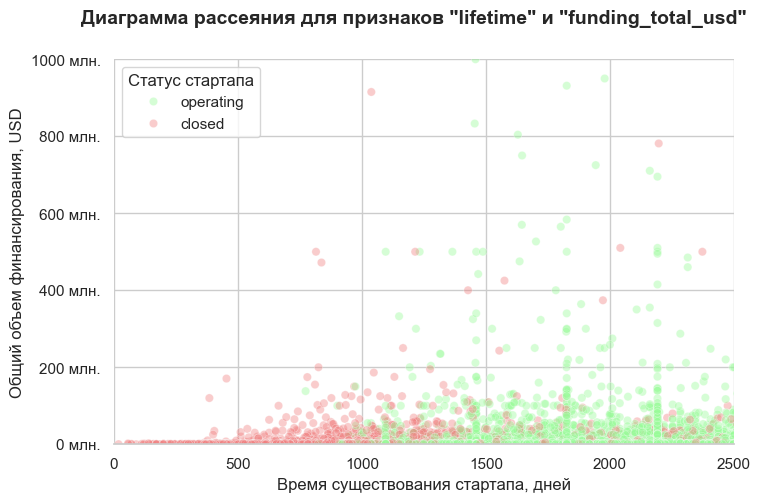

In [47]:
# выводим диаграмму рассеяния для признаков lifetime и funding_total_usd
plot_scatter(
    df=train,
    columns=['lifetime', 'funding_total_usd'],
    column_labels = ['Время существования стартапа, дней', 'Общий объем финансирования, USD'],
    x_lim=2500,
    y_lim=1000000000,
    y_formatter=millions_formatter
)

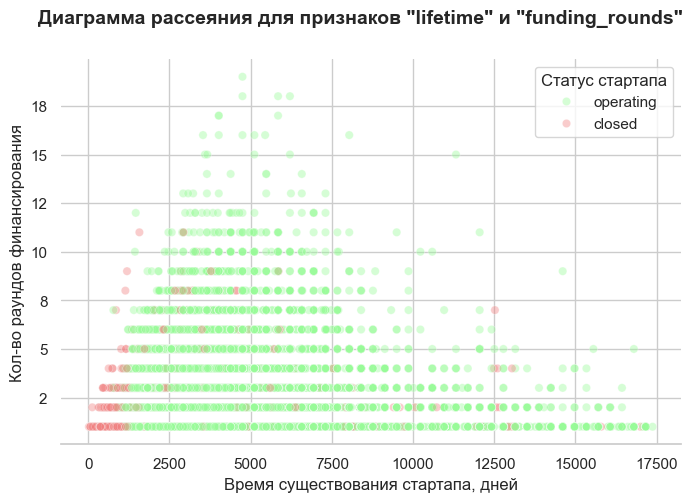

In [48]:
# выводим диаграмму рассеяния для признаков lifetime и funding_rounds
plot_scatter(
    df=train,
    columns=['lifetime', 'funding_rounds'],
    column_labels = ['Время существования стартапа, дней', 'Кол-во раундов финансирования'],
    y_formatter=int_formatter
)

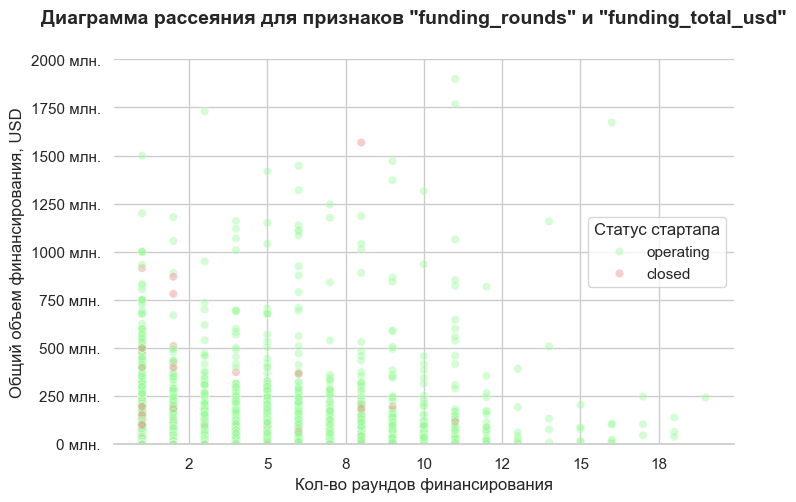

In [49]:
# выводим диаграмму рассеяния для признаков lifetime и funding_rounds
plot_scatter(
    df=train,
    columns=['funding_rounds', 'funding_total_usd'],
    column_labels = ['Кол-во раундов финансирования', 'Общий объем финансирования, USD'],
    x_formatter=int_formatter,
    y_formatter=millions_formatter,
    y_lim=2000000000
)

Определим функцию для вывода гистограммы протности распределения.

In [50]:
# функция прнимает на вход датасет, название колонки, подпись к оси x,
# масштабирование и форматирование оси x
def plot_distibution(df, col_name, col_title, x_lim=None, x_formatter=None, hue='status'):
    # задаем область рисования
    fig, ax = plt.subplots(figsize=(8, 4))
    # применяем функцию <seaborn.kdeplot()> для нивелирования размеров выборок
    sns.kdeplot(
        data=df,
        x=col_name,
        # делим по целевой переменной
        hue=hue,
        ax=ax,
        palette=palette,
        multiple='layer',
        fill=True
    )
    
    # подписываем оси и названия
    ax.set_xlabel(col_title)
    ax.set_ylabel('Плотность')
    ax.get_legend().set_title('Статус стартапа')

    # устанавливаем форматирование оси x
    if x_formatter != None:
        ax.xaxis.set_major_formatter(x_formatter)

    # масштабируем график по оси x для просмотра
    # основной плотности наблюдений
    if x_lim != None:
        ax.set_xlim(x_lim)
    
    fig.suptitle(
        f'Распределение признака {col_name}\nпо целевой переменной на тренировочной выборке',
        fontsize=12,
        fontweight='bold'
    )
    
    # убираем лишнее
    sns.despine(left=True)
    plt.show()

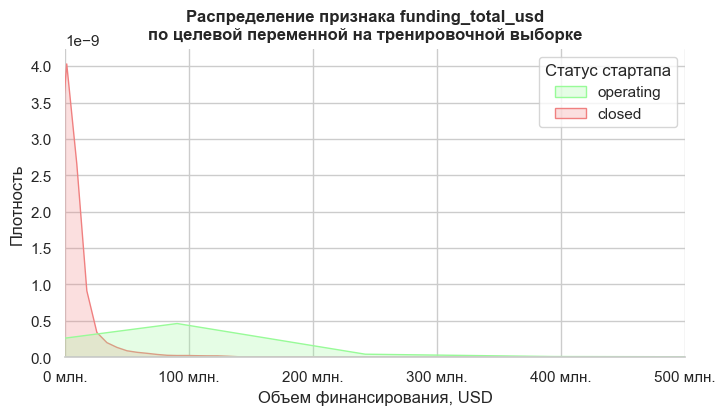

In [51]:
# выводим диаграмму рассеяния для признака funding_total_usd
plot_distibution(
    df=train,
    col_name='funding_total_usd',
    col_title='Объем финансирования, USD',
    x_formatter=millions_formatter,
    x_lim=(-10000, 500000000)
)

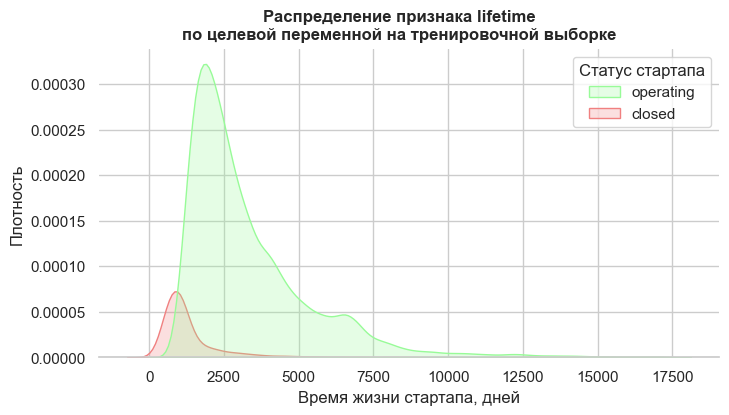

In [52]:
# выводим диаграмму рассеяния для признака lifetime
plot_distibution(
    df=train,
    col_name='lifetime',
    col_title='Время жизни стартапа, дней'
)

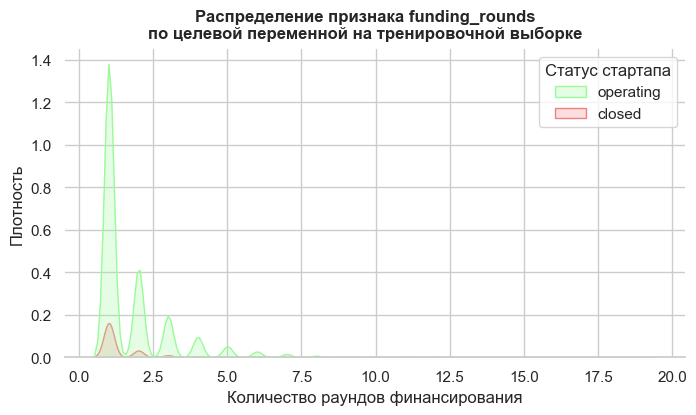

In [53]:
# выводим диаграмму рассеяния для признака lifetime
plot_distibution(
    df=train,
    col_name='funding_rounds',
    col_title='Количество раундов финансирования'
)

### Исследование категориальных признаков (целевой переменной)

Исследуем распределение целевой переменой `status` на тренировочной выборке. Для этого отобразим количественную диаграмму.

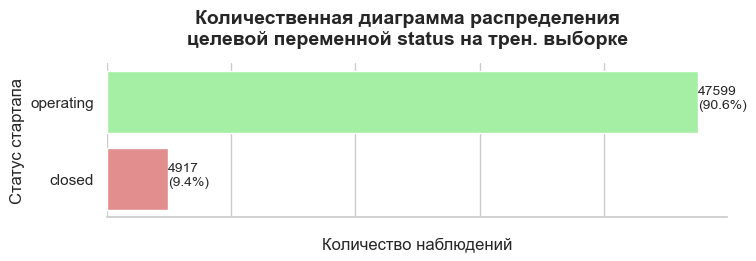

In [54]:
# задаем размеры области для рисования
fig, ax = plt.subplots(figsize=(8, 2))

# выводим количественную диаграмму
sns.countplot(
    data=train,
    y='status', 
    # устанавливаем горизонтальную ориентацию
    orient='h',
    # устанавливаем цвет и порядок по убыванию сверху вниз
    palette=palette,
    order=train['status'].value_counts().index,
    ax=ax
)

# подписываем оси
ax.set_xlabel('Количество наблюдений')
ax.set_ylabel('Статус стартапа')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
# устанавливаем аннотации значений
for p in ax.patches:
    x = p.get_width()
    y = p.get_y() + p.get_height() * 0.6
    rate = x / len(train)
    label_text = f'{x:.0f}\n({rate:.1%})'
    ax.annotate((label_text), (x, y), fontsize=10)
    pass
 
    
# выводим название для графиков
fig.suptitle(
    'Количественная диаграмма распределения\nцелевой переменной status на трен. выборке',
    fontsize=14,
    fontweight='bold',
    y=1.15
)

# убираем лишнее
sns.despine(left=True)
plt.show()

### Корелляционный анализ

Определим функцию для вывода матрицы корелляции с использованием библиотеки `phik`.

In [55]:
def plot_corr(df, interval_cols):
    # считаем корреляции
    phik_overview = phik_matrix(
        df,
        interval_cols=interval_cols
    )
    # визуализируем матрицу корреляции
    plot_correlation_matrix(
        # передаём значения матрицы корреляции
        phik_overview.values,
        
        # указываем наименования столбцов
        x_labels=phik_overview.columns,
        
        # указываем наименования строк
        y_labels=phik_overview.index,
        
        # указываем цвет градиентной отрисовки
        vmin=0, vmax=1, color_map='Greens',
        
        # добавляем заголовок
        title=r'correlation $\phi_K$',
        
        # увеличиваем размер шрифта
        fontsize_factor=1.5,
        
        # увеличиваем размер графика
        figsize=(20, 15)
    )
    pass

Отберем признаки для корелляционного анализа.

In [56]:
# категориальные признаки
cat_columns = [
    'status',
    'country_code',
    'state_code',
    'region',
    'city'
]

# количественные признаки
interval_cols = [
    'funding_total_usd',
    'lifetime',
    'funding_rounds'
]

/opt/anaconda3/envs/masterskaya/lib/python3.12/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 4643686. Are interval variables set correctly?
  warnings.warn(


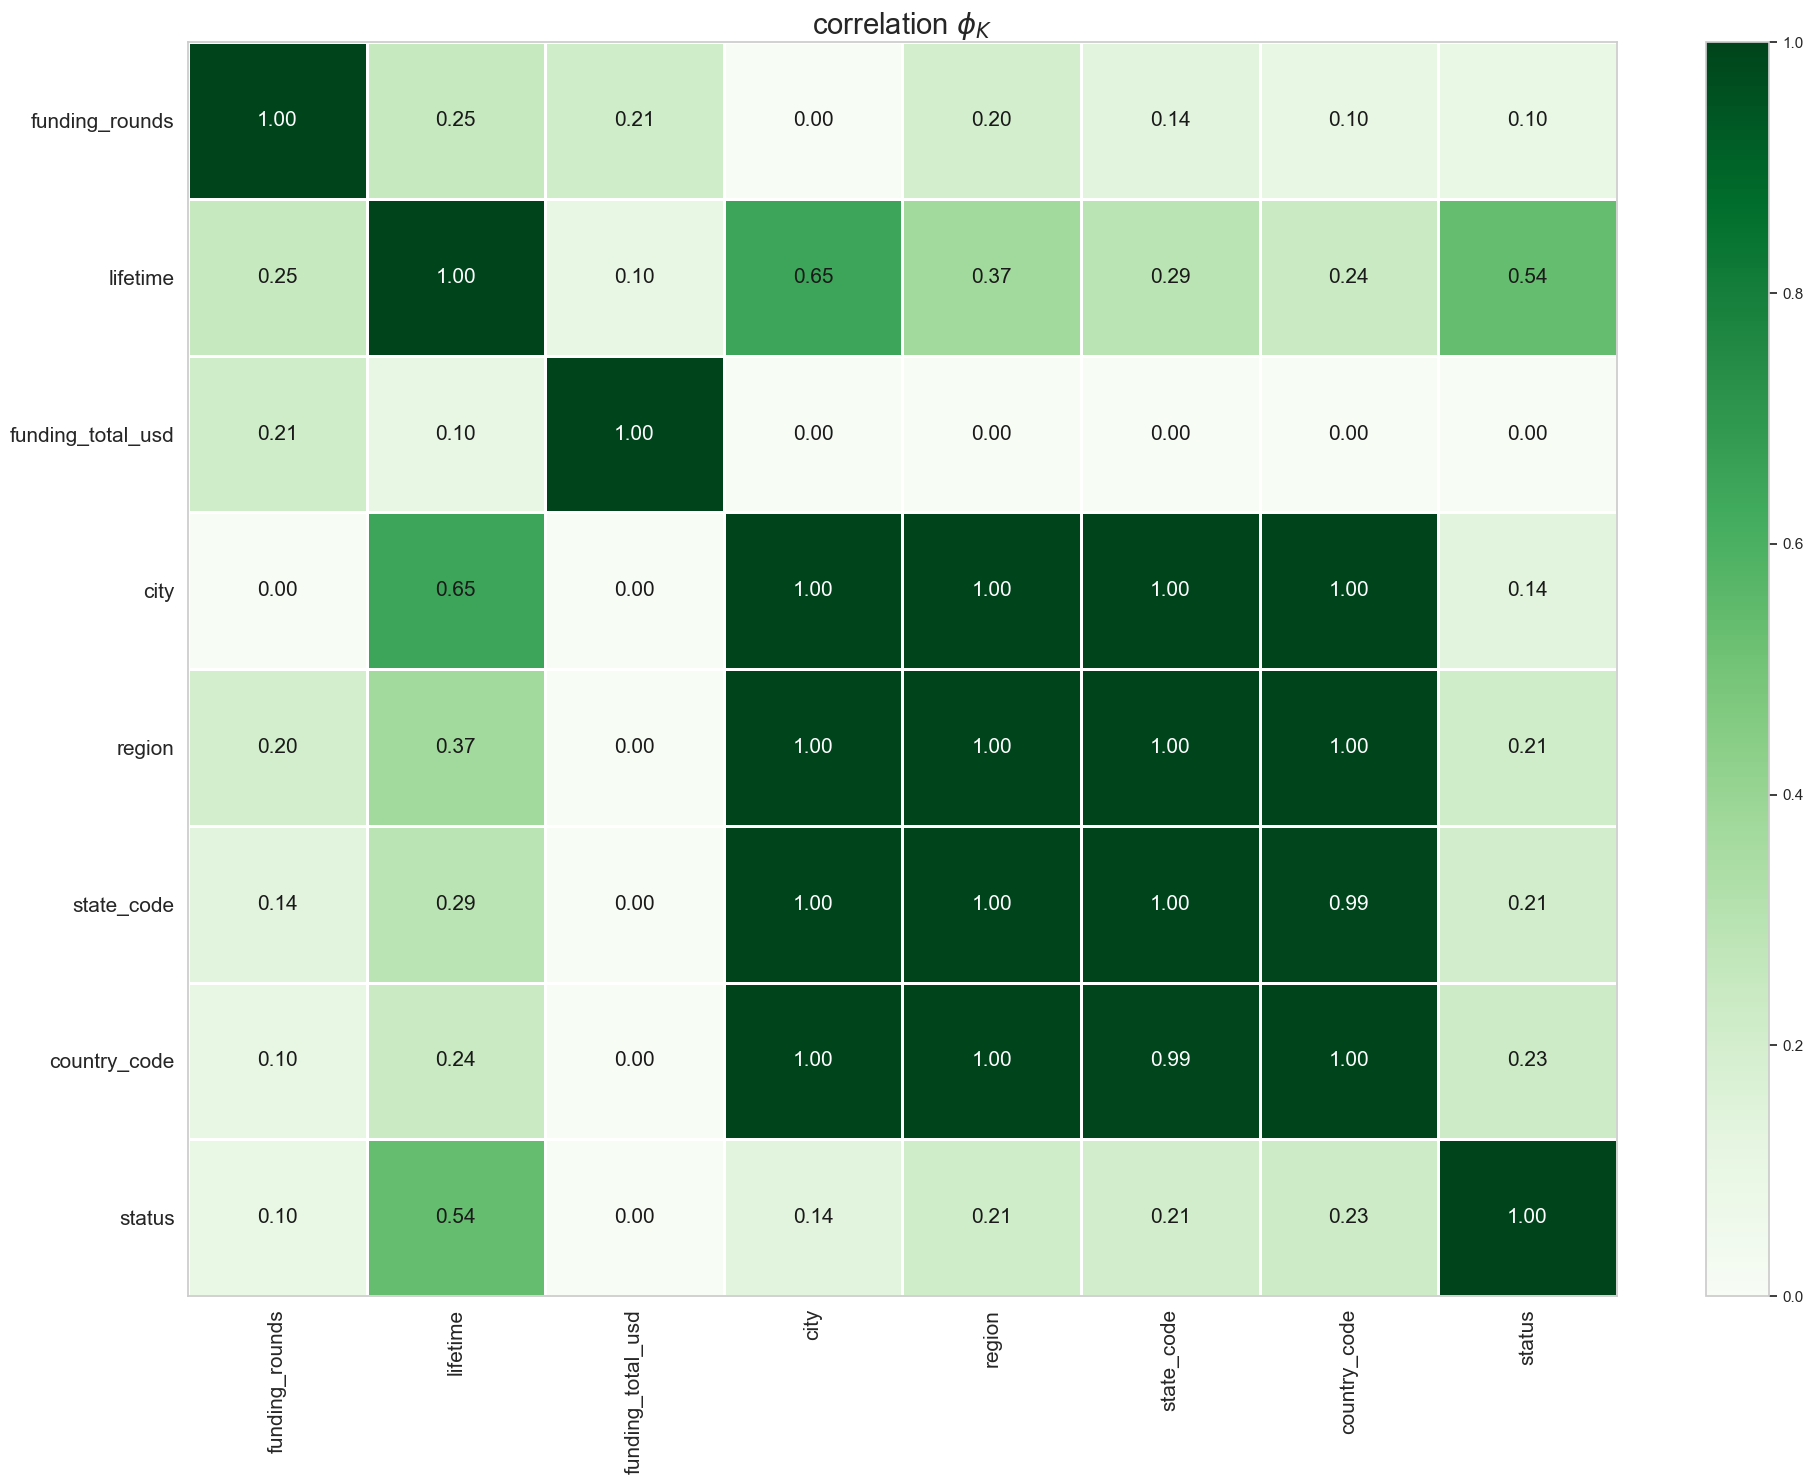

In [57]:
# выводим матрицу корелляции
plot_corr(train[cat_columns + interval_cols], interval_cols)

In [58]:
cat_columns.remove('status')

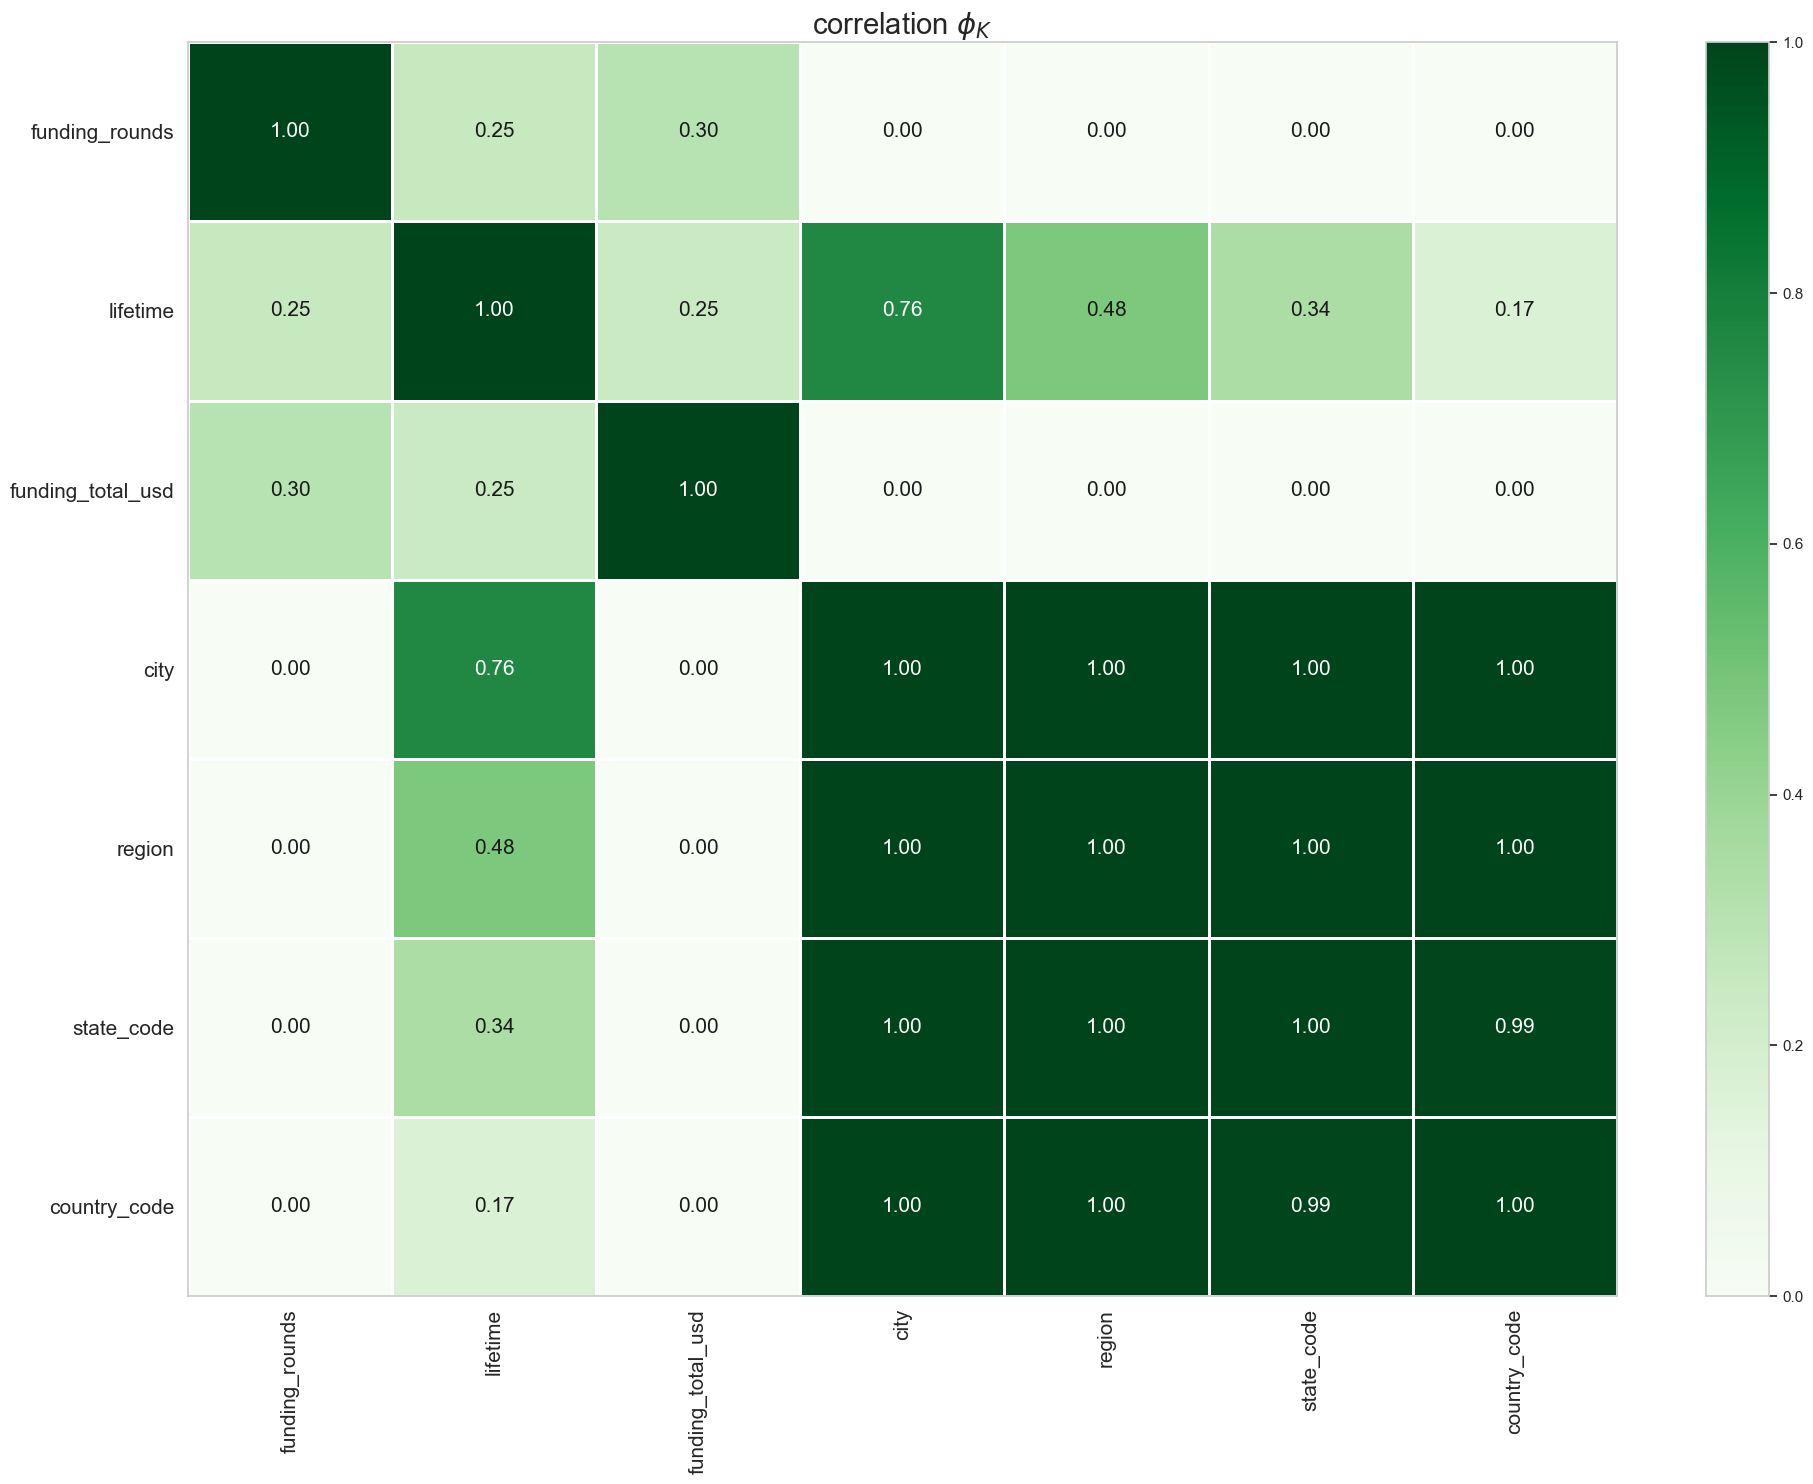

In [59]:
# выводим матрицу корелляции
plot_corr(test[cat_columns + interval_cols], interval_cols)

### Промежуточные выводы по исследовательскому анализу

- Признаки `coutry_code`, `ctate_code`, `region` и `city` на 100 % кореллирую между собой. Для обучения модели можно оставить только один из них - `coutry_code`. Он сильнее всего кореллирует с таргетом.
- Целевая переменная несбалансирована. При подготовке данных и обучени моделей необходимо использовать инструменты для баланса классов.
- Признак `lifetime` сильнее всего кореллирует с целевой переменной.

## Подготовка данных

Определим класс для работы с текстовыми данными в `Pipeline`. Для этого создадим кастомный `ColumnTransformer`, работающий на основе класса `Word2Vec` из библиотеки `gensim`.

In [60]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, vector_size=100, min_count=1):
        """
        Класс для преобразования текстовых фраз и предложений в векторное представление.
        Адаптирован для использования в пайплайне.
        
        Атрибуты:
        ----------
        vector_size : int
            Размерность вектора, которым кодируется строка.
        min_count : int
            Минимальное количество повторений слова, чтобы оно не было игнорировано алгоритмом.
        """
        self.vector_size = vector_size
        self.min_count = min_count

    
    def fit(self, X, y=None):
        """
        Возвращает объект настоящего класса.
        
        Возвращаемое значение:
        -----------------------
        Word2VecTransformer : Обученная модель для кодирования текста.
        """
        # разбивка текстовых выражений на токены и сортировка
        # например было Events|Android Dev|Apps, стало [android_dev, apps, events]
        sentences = sorted([sentence.split('|') for sentence in X[X.columns[0]]])
        # инициализация модели и передача токенов
        self.model = Word2Vec(sentences, vector_size=self.vector_size, min_count=self.min_count)
        self.is_fitted_ = True
        return self
        
    def transform(self, X):
        """
        Возвращает массив векторов как результат кодирования.
        
        Возвращаемое значение:
        -----------------------
        numpy.ndarray : векторное представление текстовых данных.
        """
        result = []
        sentences = sorted([sentence.split('|') for sentence in X[X.columns[0]]])
        for sentence in sentences:
            vectors = [self.model.wv[word] for word in sentence if word in self.model.wv]
            if len(vectors) > 0:
                result.append(np.mean(vectors, axis=0))
            else:
                result.append(np.zeros(self.model.vector_size))
        return np.array(result)

На основе исследовательского анализа отберем признаки для поиска лучших гиперпараметров и обучения моделей.

In [61]:
# создаём списки с названиями признаков по категориям подготовки
cat_columns = [
    'country_code'
]

num_columns = [
    'funding_total_usd',
    'lifetime',
    'funding_rounds'
]

word2vec_columns = [
    'category_list'
]

Инициализируем `ColumnTransformer`: кодирование, масштабировние и векторизация текста.

In [62]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(smoothing=10), cat_columns),
        ('num', StandardScaler(), num_columns),
        ('text', Word2VecTransformer(vector_size=50, min_count=1), word2vec_columns)
    ],
    remainder='passthrough'
)

In [63]:
# объединяем в один список
features = cat_columns + num_columns + word2vec_columns

In [64]:
# получаем срезы по столбцам
X = train[features]
y = train['status']

## Обучение моделй и подбор гиперпараметров

In [65]:
# делим выборку на тренировочную и тестовую
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    # целевая переменная несбалансирована, указываем стратификацию
    stratify=y
)

Кодирование целевой переменной.

In [66]:
# применение LabelEncoder к целевой переменной
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)

In [67]:
list(le.classes_)

['closed', 'operating']

`0` - 'closed', `1` - 'operating'.

Для подбора гиперпараметров используем инструменты `optuna`. Определим функцию для перебора гиперпараметров.

In [68]:
# функция принимает на вход объект trial (проба) и имя модели
def objective(trial, model_name):
   
    # определяем гиперпараметры для каждой модели
    if model_name == 'CatBoostClassifier':
        
        # определяем гиперпараметры для CatBoostClassifier
        depth=trial.suggest_int('cb_depth', 4, 10)
        learning_rate=trial.suggest_float('cb_learning_rate', 0.01, 0.3)
        iterations=trial.suggest_int('cb_iterations', 10, 1000)
        l2_leaf_reg=trial.suggest_int('cb_l2_leaf_reg', 1, 10)
        border_count=trial.suggest_int('cb_border_count', 1, 255)
        bagging_temperature=trial.suggest_float('cb_bagging_temperature', 0.0, 1.0)
        random_strength=trial.suggest_float('cb_random_strength', 0.0, 1.0)
        
        # инициализируем классификатор
        classifier_obj=CatBoostClassifier(
            random_seed=RANDOM_STATE,
            verbose=False,
            #auto_class_weights='Balanced',
            depth=depth,
            learning_rate=learning_rate,
            iterations=iterations,
            l2_leaf_reg=l2_leaf_reg,
            border_count=border_count,
            bagging_temperature=bagging_temperature,
            random_strength=random_strength
            #cat_features = [104, 105]
        )
        
    elif model_name == 'LGBMClassifier':
        
        # определяем гиперпараметры для LGBMClassifier
        num_leaves=trial.suggest_int('lgbm_num_leaves', 4, 50)
        learning_rate=trial.suggest_float('lgbm_learning_rate', 0.01, 0.2)
        n_estimators=trial.suggest_int('lgbm_n_estimators', 10, 1000)
        min_child_samples=trial.suggest_int('lgbm_min_child_samples', 10, 50)
        
        # инициализируем классификатор
        classifier_obj = lgb.LGBMClassifier(
            random_state=RANDOM_STATE,
            objective='binary',
            #class_weight='balanced',
            num_leaves=num_leaves,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            min_child_samples=min_child_samples,
            n_jobs=-1
            #categorical_feature=[103, 104]
        )

    # создаём общий пайплайн для подготовки данных
    # используем пайплайн из библиотеки imblearn
    # для совместимости с инструментом SMOTETomek (undersampling)
    pipeline = ImbPipeline(
        steps=[
            ('preprocessor', data_preprocessor),
            ('smotetomek', SMOTETomek(random_state=RANDOM_STATE)),  # балансировка
            ('classifier', classifier_obj)
        ]
    )
    
    # обучаем и оцениваем модель
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    
    # используем метрику F1 на валидационных данных
    return f1_score(y_valid, y_pred)
    pass

Для классификации будем использовать `LGBMClassifier` и `CatBoostClassifier`.

In [69]:
# список моделей
models = ['LGBMClassifier', 'CatBoostClassifier']

In [70]:
%%time
# cоздаем и запускаем исследование
study = optuna.create_study(direction="maximize")

# класс для подавления логов
with SuppressOutput():
    # выбираем модель из списка
    for model_name in models:
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, model_name), n_trials=70)

CPU times: user 2h 44min 4s, sys: 13min 40s, total: 2h 57min 44s
Wall time: 28min 30s


In [71]:
# выводим результаты
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Best hyperparameters: ", trial.params)

Best trial:
Value: 0.9673662119622246
Best hyperparameters:  {'cb_depth': 10, 'cb_learning_rate': 0.1761897124649569, 'cb_iterations': 738, 'cb_l2_leaf_reg': 4, 'cb_border_count': 224, 'cb_bagging_temperature': 0.04669964248250946, 'cb_random_strength': 0.611543332964933}


In [72]:
# инициализируем словарь гиперпараметров для модели
params = {
    'random_seed': RANDOM_STATE,
    'verbose': False,
    'depth': 10,
    'learning_rate': 0.1761897124649569,
    'iterations': 738,
    'l2_leaf_reg': 4,
    'border_count': 224,
    'bagging_temperature': 0.04669964248250946,
    'random_strength': 0.611543332964933
}

In [73]:
# инициализируем модель с лучшими найденными гиперпараметрами
cb_model = CatBoostClassifier(**params)

In [74]:
# создаем пайплайн
pipeline = ImbPipeline(
    steps=[
        # подготовка данных
        ('preprocessor', data_preprocessor),
        # undersampling
        ('smotetomek', SMOTETomek(random_state=RANDOM_STATE)),  # балансировка
        # модель
        ('classifier', cb_model)
    ]
)

In [75]:
# запускаем обучение
with SuppressOutput():
    pipeline.fit(X_train, y_train)

In [76]:
# получаем предикты на валидационной выборке
valid_predictions = pipeline.predict(X_valid)

In [77]:
# получаем предикты тестовой выборке
submit_predictions = pipeline.predict(test[features])

In [78]:
# считаем метрики
print(f'Метрика F1 на валидационной выборке: {f1_score(y_valid, valid_predictions)}')
print(f'Метрика Recall на валидационной выборке: {recall_score(y_valid, valid_predictions)}')
print(f'Метрика Precision на валидационной выборке: {precision_score(y_valid, valid_predictions)}')
print(f'Метрика Accuracy на валидационной выборке: {accuracy_score(y_valid, valid_predictions)}')

Метрика F1 на валидационной выборке: 0.9663900850750972
Метрика Recall на валидационной выборке: 0.9663900850750972
Метрика Precision на валидационной выборке: 0.9663900850750972
Метрика Accuracy на валидационной выборке: 0.9390708301599391


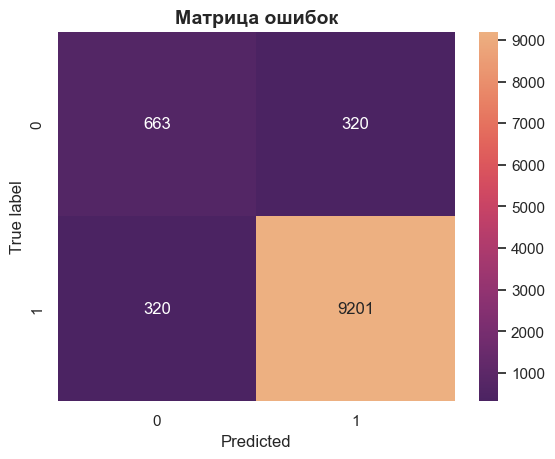

In [79]:
# построение матрицы ошибок
cm = confusion_matrix(y_valid, valid_predictions)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='flare_r')
ax.set_title(
    'Матрица ошибок',
    fontsize=14,
    fontweight='bold'
)
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

## Создание файла с предсказаниями

In [80]:
# функция для сохранения submit-файла в нужном формате
def save_submission(predictions, file_name):
    predictions = pd.DataFrame(le.inverse_transform(predictions))
    submission = test.join(predictions)
    submission = submission[['name', 0]]
    submission.columns = ['name', 'status']
    submission = submission.set_index('name')
    submission.to_csv(file_name)
    return submission

In [81]:
# передаем тестовые данные и имя файла
save_submission(submit_predictions, 'submission.csv')

,status
name,
Crystalsol,closed
JBI Fish & Wings,operating
COINPLUS,closed
Imagine Communications,operating
DNA13,operating
...,...
Jymob,operating
GlobaTrek,operating
Inkd.com,operating


## Итоговые выводы по результатам исследования

### Главная задача проекта:
На основе данных о стартапах, функционировавших в период с 1970 по 2018 годы, разработать ML-модель и предсказать, какие из них закроются.


### Основные выполненные этапы:
- загрузка и ознакомление с данными
- предварительная обработка
- исследовательский анализ
- разработка новых синтетических признаков
- проверка на мультиколлинеарность
- отбор финального набора обучающих признаков
- выбор и обучение моделей
- подбор гиперпараметров
- итоговая оценка качества предсказания лучшей модели

### Использованные библиотеки и технологии:

- **Pandas**: для работы с данными, включая их обработку, преобразование и анализ.
- **Seaborn** и **Matplotlib**: для визуализации данных и построения графиков.
- **Phik**: для расчета корреляции с учетом категориалных признаков.
- **Scikit-learn**: библиотека для машинного обучения, предоставляющая инструменты для подготовки данных, работы с метриками и моделями.
- **Optuna**: платформа для автоматизированного поиска гиперпараметров. В проекте используется интеграция Optuna с Scikit-learn.
- **Imbalanced-learn**: используется для работы с несбалансированными данными, включая методы балансировки классов, такие как **SMOTETomek**, которые помогают комбинировать методы **undersampling and oversampling** чтобы сбалансировать классы.
- **Category Encoders (TargetEncoder)**: для кодирования категориальных признаков с использованием информации о целевом признаке.
- **CatBoost** и **LightGBM**: популярные библиотеки для градиентного бустинга.
- **Word2Vec (Gensim)**: для преобразования текстовых данных в векторные представления, что используется в задачах обработки естественного языка и анализа текстов.

### Полученные результаты:

Набор данных (около 53000 наблюдений) был разделен на тренировочную и валидационную выборку. Подбор гиперпараметров и обучение моделей проводилось на тренироваочной выборке, оценка качества проведена на валидационной, которую модель не видела при обучени.
При оценка качества модели получены следующие метрики:
- Метрика F1 на валидационной выборке: **0.9663900850750972**
- Метрика Recall на валидационной выборке: **0.9663900850750972**
- Метрика Precision на валидационной выборке: **0.9663900850750972**
- Метрика Accuracy на валидационной выборке: **0.9390708301599391**